# Molecular Spectral Latent Modelling
- Jan Andrzejczyk
- Marcel Wilanowicz

In [45]:
import random
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import selfies as sf
import re
import csv
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.signal import find_peaks
import numpy as np

## 1. Loading and analyzing the dataset structure

Dataset taken from: https://zenodo.org/records/11611178

In [5]:
##### DON'T RUN THIS CELL AGAIN #####
''' A random sample of k=10 files was loaded for preliminary analysis, 
which corresponds to approximately 4% of the entire collection.'''

# Directory containing full dataset
DATA_DIR = "multimodal_spectroscopic_dataset"

# List of all .parquet files in DATA_DIR directory
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet"))) 
print(f"Found {len(paths)} .parquet files in total.")

# Random sample of k=10 files from the list "paths"
k = 10
sample_paths = random.sample(paths, k=k)

dfs = [] # DataFrames list
rows_total = 0 # Total rows counter

# Iterate over .parquet files in the sample
for p in sample_paths:
    df = pd.read_parquet(p) # Load .parquet file into DataFrame
    dfs.append(df) # Append DataFrame to the list
    print(os.path.basename(p), "->", len(df), "records") # Print file name and number of records in it
    rows_total += len(df) # Update total rows counter

data = pd.concat(dfs, ignore_index=True) # Concatenate all DataFrames into a single DataFrame "data"

print("-" * 50)
print(f"Loaded {rows_total:,} records from {k} files in total.")
print("Average number of records per file: ", rows_total / k)
print("List of data features:", list(data.columns))

Found 245 .parquet files in total.
aligned_chunk_193.parquet -> 3242 records
aligned_chunk_38.parquet -> 3260 records
aligned_chunk_50.parquet -> 3194 records
aligned_chunk_63.parquet -> 3143 records
aligned_chunk_47.parquet -> 3249 records
aligned_chunk_5.parquet -> 3292 records
aligned_chunk_42.parquet -> 3174 records
aligned_chunk_218.parquet -> 3258 records
aligned_chunk_44.parquet -> 3166 records
aligned_chunk_86.parquet -> 3236 records
--------------------------------------------------
Loaded 32,214 records from 10 files in total.
Average number of records per file:  3221.4
List of data features: ['smiles', 'hsqc_nmr_peaks', 'hsqc_nmr_spectrum', 'h_nmr_peaks', 'h_nmr_spectra', 'molecular_formula', 'c_nmr_peaks', 'ir_spectra', 'msms_positive_10ev', 'msms_positive_20ev', 'msms_positive_40ev', 'msms_fragments_positive', 'msms_negative_10ev', 'msms_negative_20ev', 'msms_negative_40ev', 'msms_fragments_negative', 'c_nmr_spectra']


The *multimodal_spectroscopic_dataset* catalog contains 245 files in .parquet format.  
A random sample of k=10 files contains an average of approximately 3,200 records per file.  
Each record describes one chemical molecule and consists of 17 features:

| Feature | Description |
|--------|------|
| smiles | chemical structure in SMILES notation |
| hsqc_nmr_peaks | list of peaks in the HSQC NMR spectrum |
| hsqc_nmr_spectrum | full HSQC NMR spectrum in the form of a table of values |
| h_nmr_peaks | list of ¹H NMR peaks (frequencies, integrals) |
| h_nmr_spectra | full ¹H NMR spectrum as an intensity vector |
| molecular_formula | molecular formula (e.g., C19H9F5O4S) |
| c_nmr_peaks | list of ¹³C NMR peaks |
| ir_spectra | IR spectrum (absorbance as a function of wave number) |
| msms_positive_10ev | MS/MS spectrum in positive mode at 10 eV energy |
| msms_positive_20ev | MS/MS spectrum in positive mode at 20 eV energy |
| msms_positive_40ev | MS/MS spectrum in positive mode at 40 eV energy |
| msms_fragments_positive | positive ion fragments with assigned formulas |
| msms_negative_10ev | MS/MS spectrum in negative mode at 10 eV energy |
| msms_negative_20ev | MS/MS spectrum in negative mode at 20 eV energy |
| msms_negative_40ev | MS/MS spectrum in negative mode at 40 eV energy |
| msms_fragments_negative | negative ion fragments with assigned formulas |
| c_nmr_spectra | full ¹³C NMR spectrum |

### 1.1 Terminology

SMILES – a textual representation of a chemical structure (atoms, bonds, rings written as a string of characters).

Molecular formula – counts how many atoms of each element a molecule contains (e.g., C15H12BrFN4).

NMR (nuclear magnetic resonance) – a technique that allows to determine which atoms are present in a molecule and in what chemical environment they are found.
- ¹H NMR – signals from protons (hydrogen atoms).  
- ¹³C NMR – signals from carbon atoms.
- HSQC – two-dimensional ¹H–¹³C spectrum that combines protons with their corresponding carbon atoms.
- Peak – a single signal in the spectrum.  
- Integral – the area under the ¹H NMR peak. Indicates how many protons produce a given signal.
- Spectrum – a list of signal intensities as a function of frequency (ppm).

IR (infrared spectroscopy) – a spectrum of molecular vibrations. Different functional groups absorb IR radiation at characteristic locations, which allows them to be identified.

MS/MS (tandem mass spectrometry) – a technique that breaks a molecule into fragments and measures their masses.
- m/z – mass-to-charge ratio of an ion.
- Positive/negative mode – ionization method (cations or anions).  
- 10/20/40 eV – fragmentation energy; higher energy produces more fragments.
- Fragments – a list of fragments with their assigned formulas.

Each of these data types comes from a different measurement technique and describes a different property of the same molecule. The set includes a text structure, 1D spectra, 2D spectra, mass spectra, and an IR spectrum, so it is **multimodal** (it contains multiple data modalities at once).

In [ ]:
# Example SMILES of median length
median_length = data["smiles"].str.len().median() # Calculate median length of SMILES strings
one = data.iloc[(data["smiles"].str.len() - median_length).abs().argsort()[:1]][["smiles", "molecular_formula"]] # Find the record with SMILES length closest to the median
print(one.to_dict(orient="records")[0])

{'smiles': 'CC(C)(C)OC(=O)C=C1CCn2c1cc1cc(C#N)ccc12', 'molecular_formula': 'C18H18N2O2'}


### 1.2 Analysis of other dataset properties

In [28]:
# Function to count all elements in a SMILES string
def count_elements(smiles):
    elements = re.findall(r"[A-Z][a-z]?", smiles)  # Find all element symbols (C, Cl, Br, N, O...)
    return len(set(elements))  # Count unique elements in the molecule

data["n_elements"] = data["smiles"].map(count_elements)

data["is_organic"] = data["smiles"].str.contains("C")

data["smiles_len"] = data["smiles"].str.len()

organic_percentage = round(data["is_organic"].mean() * 100, 2)
median_smiles_len = int(data["smiles_len"].median())
median_num_elements = int(data["n_elements"].median())

print("Percentage of organic molecules in dataset:", organic_percentage, "%")
print("Median length of SMILES molecule:", median_smiles_len, "characters")
print("Median number of elements:", median_num_elements)

Percentage of organic molecules in dataset: 99.61 %
Median length of SMILES molecule: 39 characters
Median number of elements: 4


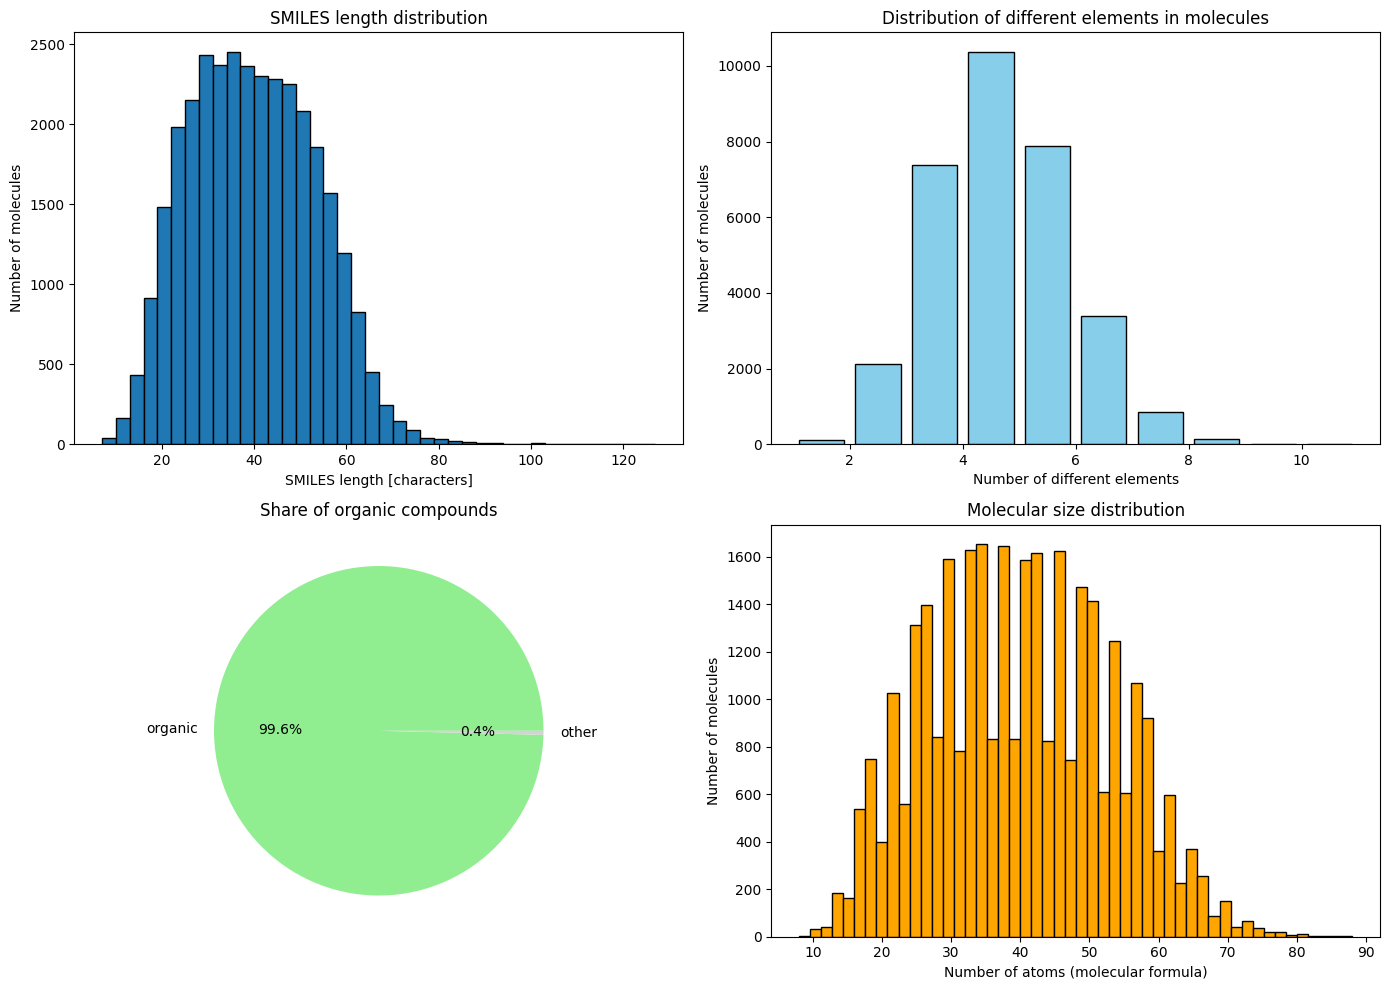

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

n_molecules = len(data)

# 1. SMILES length histogram
ax1.hist(data["smiles_len"], bins=40, edgecolor="black")
ax1.set_xlabel("SMILES length [characters]")
ax1.set_ylabel("Number of molecules")
ax1.set_title(f"SMILES length distribution")

# 2. Histogram of number of elements
ax2.hist(
    data["n_elements"].dropna(),
    bins=range(1, 12),
    rwidth=0.8,
    color="skyblue",
    edgecolor="black"
)
ax2.set_xlabel("Number of different elements")
ax2.set_ylabel("Number of molecules")
ax2.set_title(f"Distribution of different elements in molecules")

# 3. Pie chart organic / other
counts = data["is_organic"].value_counts()
ax3.pie(
    counts,
    labels=["organic", "other"],
    autopct="%.1f%%",
    colors=["lightgreen", "lightgray"]
)
ax3.set_title("Share of organic compounds")

# 4. Histogram of the number of atoms
def atom_count(formula):
    nums = re.findall(r"\d+", str(formula))
    return sum(map(int, nums)) if nums else None

data["atom_count"] = data["molecular_formula"].map(atom_count)

ax4.hist(
    data["atom_count"].dropna(),
    bins=50,
    color="orange",
    edgecolor="black"
)
ax4.set_xlabel("Number of atoms (molecular formula)")
ax4.set_ylabel("Number of molecules")
ax4.set_title("Molecular size distribution")

plt.tight_layout()
plt.savefig("all_plots_combined.png", dpi=150)
plt.show()

**SMILES length distribution (top-left).**

Most molecules contain 30–50 characters in their SMILES representation.
The distribution is unimodal with a long but sparse tail that extends beyond 80 characters.

**Number of different elements (top-right).**

The majority of molecules contain 4–6 unique chemical elements.
Structures with more than eight elements appear only occasionally, indicating limited elemental diversity.

**Share of organic compounds (bottom-left).**

The dataset is overwhelmingly organic: 99.6% of molecules include at least one carbon atom.
Non-organic structures form only a very small fraction.

**Molecular size distribution (bottom-right).**

Based on atomic counts extracted from molecular formulas, most molecules contain 25–50 atoms.
The distribution is smooth and unimodal, characteristic of small to medium organic molecules.

### 1.3 Hydrogen distribution in the dataset:

Terminology:

• chemical compound = recipe (definition of a substance)

• molecule = one instance of a recipe (one physical object composed of atoms)

In [41]:
# Function counting how many hydrogen atoms a molecule has,
# based on its molecular formula (e.g., "C15H12BrFN4")
def count_h_from_formula(formula):

    # check if the value is a string
    if not isinstance(formula, str):
        return 0

    # search for "H", optionally followed by digits ("H", "H2", "H12", ...)
    m = re.search(r'H(\d*)', formula)

    # if no hydrogen fragment found → 0
    if m is None:
        return 0

    # digits after "H" (empty string if no number)
    num_str = m.group(1)

    # if nothing after "H" → exactly 1 hydrogen atom
    if num_str == "":
        return 1

    # convert the number to int (e.g. "12" → 12)
    return int(num_str)

In [42]:
# Dictionary counting how many molecules have a given number of H atoms
# e.g. {12: 8421, 10: 7900, 8: 6540, 15: 3000, 1: 120}
h_distribution = Counter()

# Counter of all molecules
total_molecules = 0

# Iterate over all .parquet files
for p in paths:
    # load only the "molecular_formula" column (RAM-efficient)
    df = pd.read_parquet(p, columns=["molecular_formula"])
    # debug info for the file (optional)
    # print(os.path.basename(p), "->", len(df), "rows")

    # iterate over all formulas in this file
    for formula in df["molecular_formula"]:
        # count hydrogen atoms, e.g. C15H12N2O2 -> 12
        h_count = count_h_from_formula(formula)
        # update distribution, e.g. if H=12 → increment h_distribution[12]
        h_distribution[h_count] += 1
        # increment total molecule count
        total_molecules += 1

    del df  # free memory

print("\nTotal number of molecules:", total_molecules)
print("Number of distinct H-count values:", len(h_distribution))

# sorted distribution
print("\nDistribution of hydrogen atom counts:")
for h, count in sorted(h_distribution.items()):
    print(f"H = {h:3d} -> {count} molecules")

# most frequent H-counts
print("\nMost common hydrogen atom counts:")
for h, count in h_distribution.most_common(10):
    print(f"H = {h:3d} -> {count} molecules")


Total number of molecules: 794403
Number of distinct H-count values: 64

Distribution of hydrogen atom counts:
H =   1 -> 16 molecules
H =   2 -> 41 molecules
H =   3 -> 706 molecules
H =   4 -> 2242 molecules
H =   5 -> 5887 molecules
H =   6 -> 10159 molecules
H =   7 -> 14728 molecules
H =   8 -> 19858 molecules
H =   9 -> 24940 molecules
H =  10 -> 30000 molecules
H =  11 -> 32982 molecules
H =  12 -> 37758 molecules
H =  13 -> 38912 molecules
H =  14 -> 42241 molecules
H =  15 -> 40680 molecules
H =  16 -> 42861 molecules
H =  17 -> 40471 molecules
H =  18 -> 42178 molecules
H =  19 -> 38987 molecules
H =  20 -> 39120 molecules
H =  21 -> 35819 molecules
H =  22 -> 35015 molecules
H =  23 -> 31162 molecules
H =  24 -> 29343 molecules
H =  25 -> 25474 molecules
H =  26 -> 23594 molecules
H =  27 -> 19378 molecules
H =  28 -> 17698 molecules
H =  29 -> 14106 molecules
H =  30 -> 12475 molecules
H =  31 -> 9106 molecules
H =  32 -> 8420 molecules
H =  33 -> 5964 molecules
H =  34 ->

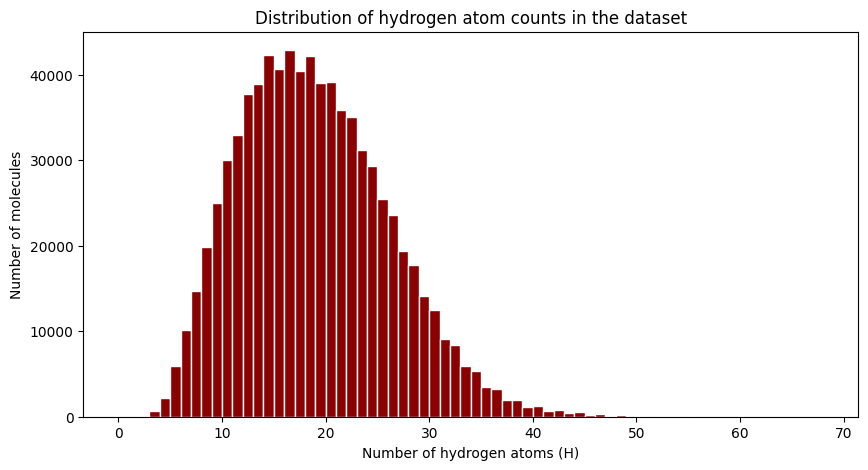

In [59]:
# Convert the Counter into a long list of H-values
# Takes the distribution (value -> frequency)
# and expands it into a list where each H-count appears 'freq' times
h_values = []
for h_count, freq in h_distribution.items():
    h_values += [h_count] * freq   # e.g. if h_count=12, freq=3 → adds [12, 12, 12]

plt.figure(figsize=(10, 5))

# +2 because histogram bins need an upper boundary,
# and range() does not include its endpoint
plt.hist(
    h_values,
    bins=range(0, max(h_values) + 2),
    edgecolor='white',
    color='darkred'
)

plt.xlabel("Number of hydrogen atoms (H)")
plt.ylabel("Number of molecules")
plt.title("Distribution of hydrogen atom counts in the dataset")
plt.show()

The histogram shows the distribution of hydrogen atom counts across all molecules in the dataset.
The values form a smooth, unimodal distribution centered around 14–20 hydrogen atoms (most molecules fall in this range).
Counts below 5 and above 40 are relatively rare, and only a handful of molecules contain more than 50 hydrogens.
This pattern reflects typical sizes of small-to-medium organic molecules present in the dataset.

### 1.4 Spectral NMR image

The dataset includes digital ¹³C NMR spectra stored as raw intensity arrays. Each spectrum is represented as a list of intensity values. The x-axis corresponds to the sample index (the ppm scale is not provided), and the y-axis shows the signal intensity. This allows visualization of the general spectral shape even without calibrated chemical shift values.

SMILES: COC(=O)c1ccc(OC)c(-n2c(C)cc(OCc3ccc(F)cc3F)cc2=O)c1


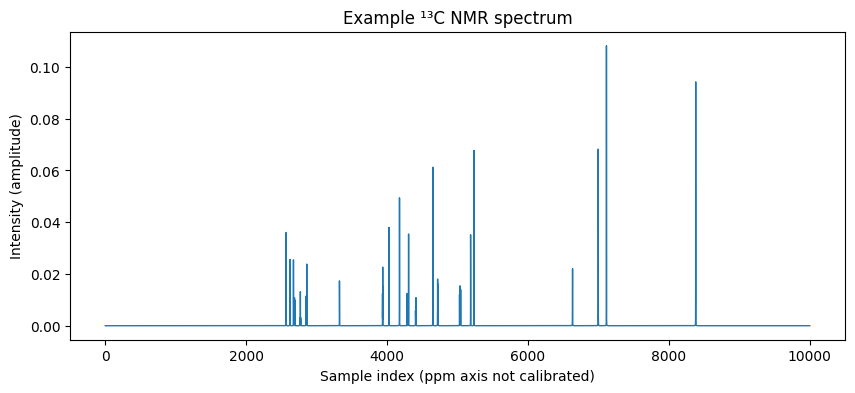

In [74]:
print("SMILES:", data["smiles"][0])

# TBD: Osobny dataset z obrazami spektrów NMR (uzupelnienie do SMILES i SELFIES)
plt.figure(figsize=(10,4))
plt.plot(data["c_nmr_spectra"][0], linewidth=1) # NMR spectrum of the first molecule in dataset
plt.title("Example ¹³C NMR spectrum")
plt.xlabel("Sample index (ppm axis not calibrated)")
plt.ylabel("Intensity (amplitude)")
plt.show()

The spectrum shows several well-defined peaks as well as long flat regions where no carbon signal is detected. The overall shape indicates that the dataset provides full digital spectra with consistent point density across molecules, even though the chemical shift scale is not available.

SMILES: COC(=O)c1ccc(OC)c(-n2c(C)cc(OCc3ccc(F)cc3F)cc2=O)c1
SMILES: CCOC(=O)c1nc2ccc(CBr)cc2o1
SMILES: C=C(CCCC)C(=O)CP(=O)(OC)OC
SMILES: C=C(Cl)CC(O)c1ccccc1
SMILES: Cc1csc(NC(=O)CCl)n1


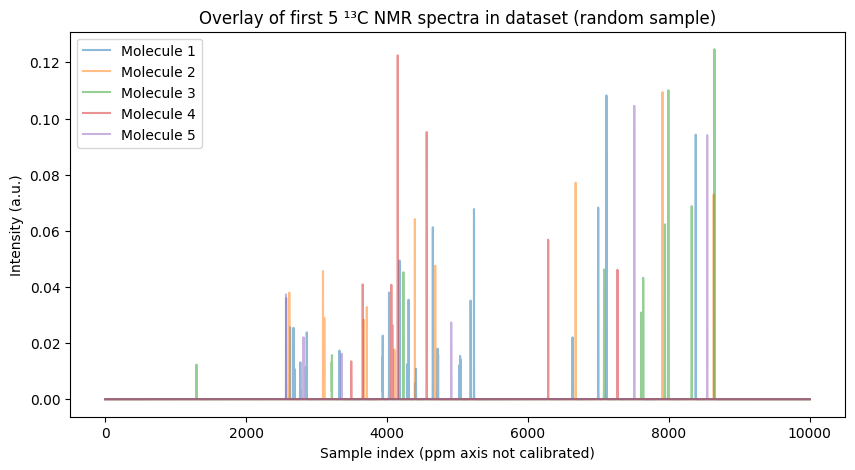

In [79]:
plt.figure(figsize=(10,5))

for i in range(5):
    smiles = data["smiles"][i]
    print("SMILES:", smiles)
    plt.plot(
        data["c_nmr_spectra"][i], 
        alpha=0.5, 
        label=f"Molecule {i+1}"
    )

plt.title("Overlay of first 5 ¹³C NMR spectra in dataset (random sample)")
plt.xlabel("Sample index (ppm axis not calibrated)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

## 2. Conversion: SMILES -> SELFIES -> CSV (streaming across all files)
New, lighter text dataset

In [64]:
# Przykładowa konwersja SMILES -> SELFIES
smiles = list(data['smiles'])

for i in range(5):
    selfie = sf.encoder(smiles[i])
    print(selfie)

[C][O][C][=Branch1][C][=O][C][=C][C][=C][Branch1][Ring1][O][C][C][Branch2][Ring1][=N][N][C][Branch1][C][C][=C][C][Branch1][#C][O][C][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][=C][C][Ring1][P][=O][=C][Ring2][Ring1][#Branch2]
[C][C][O][C][=Branch1][C][=O][C][=N][C][=C][C][=C][Branch1][Ring1][C][Br][C][=C][Ring1][Branch2][O][Ring1][O]
[C][=C][Branch1][Branch1][C][C][C][C][C][=Branch1][C][=O][C][P][=Branch1][C][=O][Branch1][Ring1][O][C][O][C]
[C][=C][Branch1][C][Cl][C][C][Branch1][C][O][C][=C][C][=C][C][=C][Ring1][=Branch1]
[C][C][=C][S][C][Branch1][Branch2][N][C][=Branch1][C][=O][C][Cl][=N][Ring1][#Branch2]


In [61]:
###### DON'T RUN THIS CELL UNLESS YOU WANT TO OVERWRITE THE CSV FILE ######
DATA_DIR = "multimodal_spectroscopic_dataset"
OUT_CSV = "smiles_selfies_full.csv"

# Find and sort all .parquet files by numeric chunk index
paths = glob.glob(os.path.join(DATA_DIR, "*.parquet"))
paths = sorted(paths, key=lambda x: int(re.findall(r"(\d+)", x)[-1]))

print("Found files:", len(paths))

# Open the CSV file once and append rows in the loop
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["smiles", "selfies"])  # CSV header

    for p in paths:
        # Load only the 'smiles' column to save RAM
        df = pd.read_parquet(p, columns=["smiles"])
        print(os.path.basename(p), "->", len(df), "records")

        for smi in df["smiles"]:
            # Skip missing or invalid SMILES entries
            if not isinstance(smi, str):
                continue
            try:
                # strict=False prevents crashes for unusual or corrupted SMILES
                selfie = sf.encoder(smi, strict=False)
            except Exception:
                selfie = ""  # fallback for invalid SMILES

            writer.writerow([smi, selfie])

        del df  # free memory after each chunk

print("Saved CSV file:", OUT_CSV)

Found files: 245
aligned_chunk_0.parquet -> 3235 records
aligned_chunk_1.parquet -> 3273 records
aligned_chunk_2.parquet -> 3129 records
aligned_chunk_3.parquet -> 3226 records
aligned_chunk_4.parquet -> 3280 records
aligned_chunk_5.parquet -> 3292 records
aligned_chunk_6.parquet -> 3233 records
aligned_chunk_7.parquet -> 3211 records
aligned_chunk_8.parquet -> 3225 records
aligned_chunk_9.parquet -> 3222 records
aligned_chunk_10.parquet -> 3244 records
aligned_chunk_11.parquet -> 3270 records
aligned_chunk_12.parquet -> 3249 records
aligned_chunk_13.parquet -> 3243 records
aligned_chunk_14.parquet -> 3239 records
aligned_chunk_15.parquet -> 3204 records
aligned_chunk_16.parquet -> 3276 records
aligned_chunk_17.parquet -> 3378 records
aligned_chunk_18.parquet -> 3281 records
aligned_chunk_19.parquet -> 3262 records
aligned_chunk_20.parquet -> 3254 records
aligned_chunk_21.parquet -> 3241 records
aligned_chunk_22.parquet -> 3240 records
aligned_chunk_23.parquet -> 3296 records
aligned_c

In [62]:
# Test of CSV file
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("smiles_selfies_full.csv")
df.head()      # first 5 records

,smiles,selfies
0,O=S(O)c1cc2c(cc1F)OC(c1ccc(F)cc1F)(c1ccc(F)cc1F)O2,[O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]
1,CN(C)Cc1cccc(C2Nc3cccc4c(=O)[nH]nc(c34)C2c2ccccc2)c1,[C][N][Branch1][C][C][C][C][=C][C][=C][C][Branch2][Ring1][P][C][N][C][=C][C][=C][C][C][=Branch1][C][=O][NH1][N][=C][Branch1][=Branch1][C][Ring1][O][=Ring1][#Branch1][C][Ring1][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][#Branch2]
2,O=C(N[C@@H](CO)c1nc2cc(Cl)ccc2[nH]1)c1ccc(C(=O)N2CC=CC2)c(Br)c1,[O][=C][Branch2][Ring1][#Branch1][N][C@@H1][Branch1][Ring1][C][O][C][=N][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring1][#Branch1][NH1][Ring1][#Branch2][C][=C][C][=C][Branch1][N][C][=Branch1][C][=O][N][C][C][=C][C][Ring1][Branch1][C][Branch1][C][Br][=C][Ring1][=C]
3,O=C(Cn1cc(I)cn1)N1CCCc2c1cnn2-c1ccc(F)cc1,[O][=C][Branch1][N][C][N][C][=C][Branch1][C][I][C][=N][Ring1][=Branch1][N][C][C][C][C][=C][Ring1][=Branch1][C][=N][N][Ring1][Branch1][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1]
4,Cc1ccc(-c2ccnc(Cl)c2)n1CC(=O)OCc1ccccc1,[C][C][=C][C][=C][Branch1][N][C][=C][C][=N][C][Branch1][C][Cl][=C][Ring1][#Branch1][N][Ring1][N][C][C][=Branch1][C][=O][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1]


## 3. SELFIES tokenization

Special tokens used in the sequential model:

| Token     | Meaning                |
|-----------|-------------------------------|
| &lt;sos&gt; | start of sequence         |
| &lt;eos&gt; | end of sequence               |
| &lt;pad&gt; | padding (length alignment) |
| &lt;unk&gt; | unknown token                 |

An example of tokenization:

[’[C]’, ‘[C]’, ‘[O]’, ‘[Branch1_1]’, ‘[C]’]

After adding special tokens and padding to align the length:


| Token        | Indeks |
|--------------|---------|
| &lt;sos&gt;        | 1       |
| [C]          | 10      |
| [C]          | 10      |
| [O]          | 23      |
| [Branch1_1]  | 41      |
| [C]          | 10      |
| &lt;eos&gt;        | 2       |
| &lt;pad&gt;        | 0       |
| &lt;pad&gt;        | 0       |
| ...          | ...       |

## 4. Encoder and decoder in VAE using GRU
### SELFIES -> [GRU Encoder] -> z -> [GRU Decoder] -> SELFIES

### Preprocessing

# TBD: Benchmarki dla modelu.

Jakie fizyczne aleznosci potencjalnie dałoby się wyizolować z tych latentow